In [2]:
!pip install gTTS pydub
!apt-get install ffmpeg
!pip install librosa numpy matplotlib dtw-python soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.9/837.9 kB 23.2 MB/s eta 0:00:00


In [3]:
from gtts import gTTS
from pydub import AudioSegment

tts1 = gTTS(text='hello', lang='en', tld='co.uk')
tts2 = gTTS(text='hello', lang='en', tld='com.au')

tts1.save('hello_you.mp3')
tts2.save('hello_friend.mp3')

# Convert
sound1 = AudioSegment.from_file('hello_you.mp3')
sound1.export('hello_you.wav', format='wav')

sound2 = AudioSegment.from_file('hello_friend.mp3')
sound2.export('hello_friend.wav', format='wav')


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


<_io.BufferedRandom name='hello_friend.wav'>

# Load and Visualize the Signals

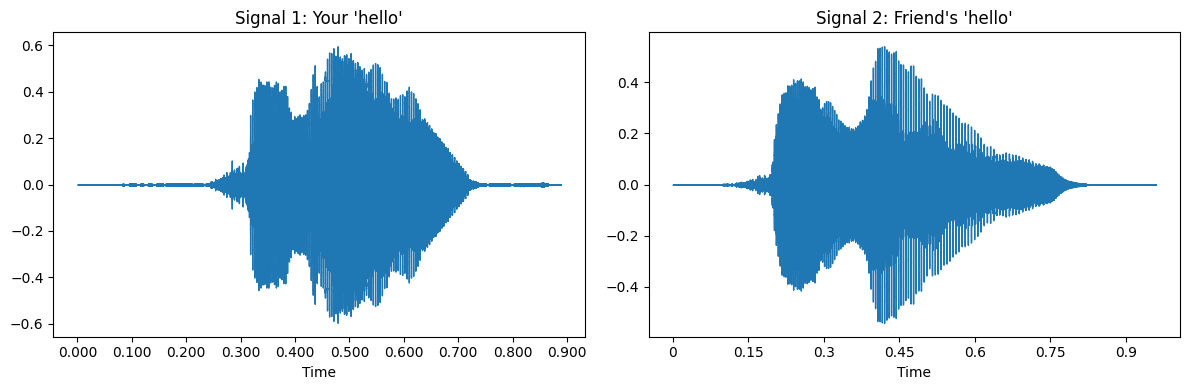

In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

sig1, sr1 = librosa.load('hello_you.wav', sr=None)
sig2, sr2 = librosa.load('hello_friend.wav', sr=None)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
librosa.display.waveshow(sig1, sr=sr1)
plt.title("Signal 1: Your 'hello'")
plt.subplot(1,2,2)
librosa.display.waveshow(sig2, sr=sr2)
plt.title("Signal 2: Friend's 'hello'")
plt.tight_layout()
plt.show()

The two audio signals ("hello" from you and your friend) have similar shapes overall, but there are clear differences in timing, amplitude, and possibly pronunciation style.

The energy envelopes peak at slightly different moments, indicating each speaker may have spoken "hello" at a slightly different pace or stress.

# Normalize Both Signals

In [5]:
def normalize(sig):
    return sig / np.max(np.abs(sig))

sig1_norm = normalize(sig1)
sig2_norm = normalize(sig2)


# Dynamic Time Warping

In [6]:
from dtw import dtw

sig1_ = sig1_norm.reshape(-1, 1)
sig2_ = sig2_norm.reshape(-1, 1)

alignment = dtw(sig1_, sig2_, dist_method='euclidean')

print("DTW distance:", alignment.distance)
print("Alignment path indices (signal 1):", alignment.index1)
print("Alignment path indices (signal 2):", alignment.index2)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

DTW distance: 890.2893597684451
Alignment path indices (signal 1): [    0     1     2 ... 21309 21310 21311]
Alignment path indices (signal 2): [    0     0     0 ... 23037 23038 23039]


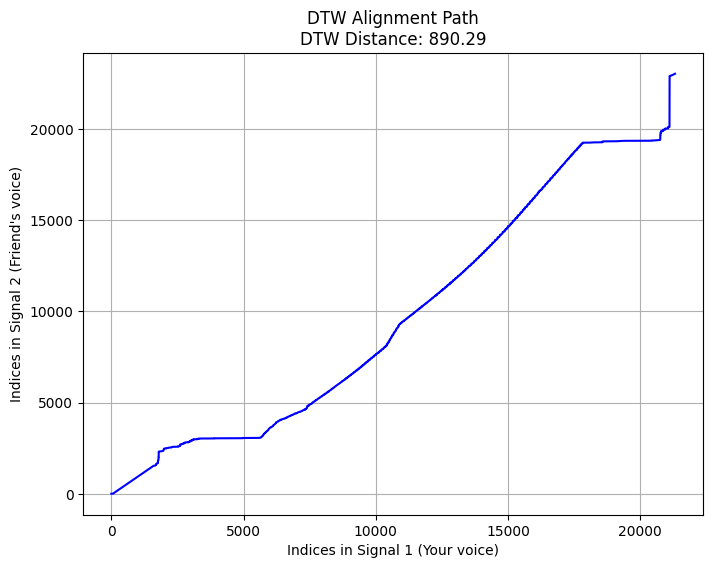

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(alignment.index1, alignment.index2, color='blue')
plt.xlabel("Indices in Signal 1 (Your voice)")
plt.ylabel("Indices in Signal 2 (Friend's voice)")
plt.title(f"DTW Alignment Path\nDTW Distance: {alignment.distance:.2f}")
plt.grid(True)
plt.show()



*   The DTW alignment path is mostly diagonal, indicating the two signals are broadly similar in time progression.
*   Some bends in the path show that DTW made small local adjustments—stretching or compressing segments—to best synchronize matching sound patterns.
*   The reported DTW distance (in your plot: 890.29) provides a quantitative measure of similarity. A lower value would suggest stronger similarity; the absolute value must be interpreted relative to signal length and scale.

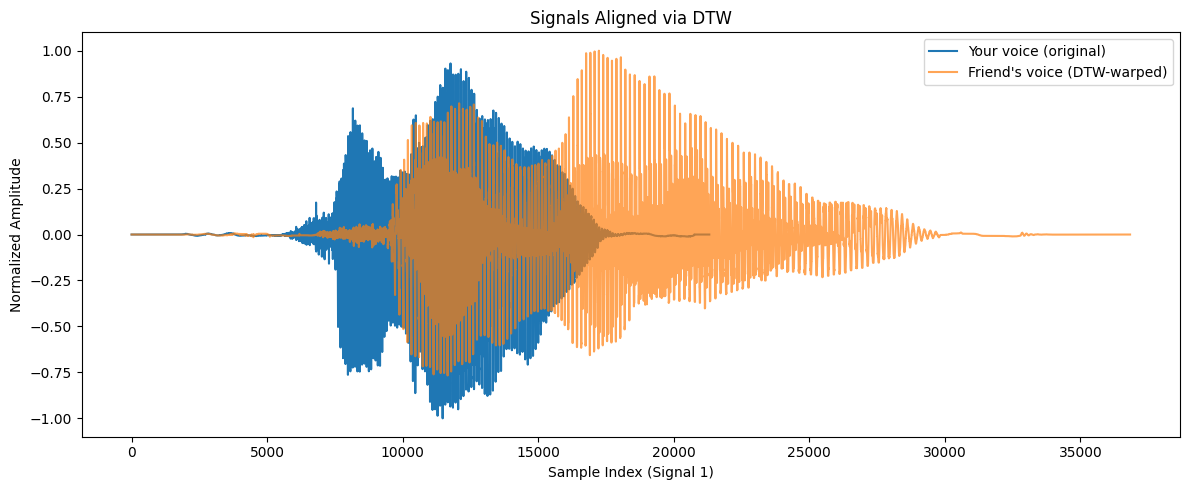

In [8]:
plt.figure(figsize=(12, 5))

# Warped signals: map Signal 1 samples to their matched Signal 2 locations
warped_sig2 = sig2_norm[alignment.index2]
plt.plot(sig1_norm, label="Your voice (original)")
plt.plot(warped_sig2, label="Friend's voice (DTW-warped)", alpha=0.7)

plt.title("Signals Aligned via DTW")
plt.xlabel("Sample Index (Signal 1)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


After DTW alignment, the two signals overlay much more closely, with similar peaks and valleys throughout the main spoken word portions.

This illustrates how DTW compensates for differences in speaking rate (one speaker starting or finishing "hello" earlier or later).

# Overall Interpretation

1.   The two audio signals are similar but not identical. Differences exist in timing, loudness, and pronunciation.
2.   DTW effectively finds the best alignment by stretching/compressing segments so that acoustically similar events (parts of "hello") are matched, even if they occur at different times in each recording.
3. DTW distance quantifies similarity: your observed value suggests moderate similarity, which is typical for two different speakers saying the same word.

DTW is robust to speed or style differences: If one speaker says "hello" faster, DTW warps the time axis to align peaks and features, optimizing for minimal overall difference.

It’s widely used for speech comparison in applications like speaker recognition, keyword spotting, and audio pattern matching.